## Machine Learning - Desafío 4, Análisis lineal discriminante
#### Gustavo Morales, G10 - 15.Ene.2020, (Miércoles Semana 2)

### **Ejercicio 1: Preparar el ambiente de trabajo**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import (classification_report, confusion_matrix, plot_confusion_matrix,
                             roc_curve, roc_auc_score)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
plt.style.use('seaborn-paper')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [2]:
#plt.style.available

In [3]:
df = pd.read_csv('default_credit.csv').drop(columns = 'index')

In [4]:
df.head(10)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
5,No,Yes,919.588530,7491.558572
6,No,No,825.513331,24905.226578
7,No,Yes,808.667504,17600.451344
8,No,No,1161.057854,37468.529288
9,No,No,0.000000,29275.268293


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [6]:
df.isnull().sum(axis = 0)  # NaN distribution columnwise

default    0
student    0
balance    0
income     0
dtype: int64

In [7]:
from scipy.stats import pearsonr
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top right hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    # rho = '\u03C1'
    ax.annotate(f'{r:.2f}', xy=(.85, .9), xycoords=ax.transAxes, fontsize=14)

In [8]:
def plot_pair_grid(dataframe, variables=None):
    grid = sns.PairGrid(data=dataframe, vars=variables, dropna=True)
    grid = grid.map_upper(sns.regplot, color='black', scatter_kws={'alpha': 0.01})
    grid = grid.map_upper(corrfunc)
    grid = grid.map_lower(sns.kdeplot, cmap='binary')
    grid = grid.map_diag(sns.distplot, kde=False, rug=False, color='black')
    plt.tight_layout()

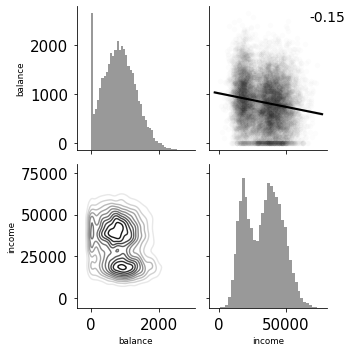

In [9]:
plot_pair_grid(df)

También son útiles los histogramas separados por estado de estudios:

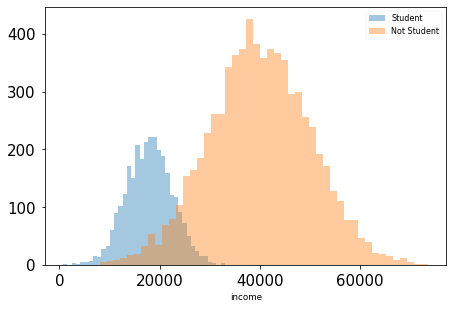

In [10]:
dfs1 = df[df.student == 'Yes']
dfs0 = df[df.student == 'No']
sns.distplot(dfs1['income'], kde=False, label='Student')
sns.distplot(dfs0['income'], kde=False, label='Not Student')
plt.legend()
plt.tight_layout()

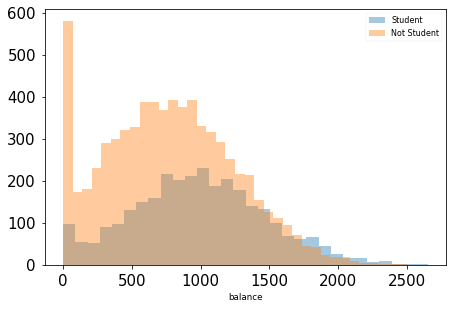

In [11]:
sns.distplot(dfs1['balance'], kde=False, label='Student')
sns.distplot(dfs0['balance'], kde=False, label='Not Student')
plt.legend()
plt.tight_layout()

### **Ejercicio 2: Modelo base**

In [12]:
df['default'] = LabelEncoder().fit_transform(df['default'])
df['student'] = LabelEncoder().fit_transform(df['student'])
df.head(10)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
5,0,1,919.588530,7491.558572
6,0,0,825.513331,24905.226578
7,0,1,808.667504,17600.451344
8,0,0,1161.057854,37468.529288
9,0,0,0.000000,29275.268293


In [13]:
X = df.drop(['default'], axis = 1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [14]:
lda_p0_model = LinearDiscriminantAnalysis()
lda_p0_model.fit(X_train,y_train);

In [15]:
lda_p0_model.priors_

array([0.96671642, 0.03328358])

In [16]:
y_pred = lda_p0_model.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3190
           1       0.79      0.25      0.38       110

    accuracy                           0.97      3300
   macro avg       0.88      0.62      0.68      3300
weighted avg       0.97      0.97      0.97      3300



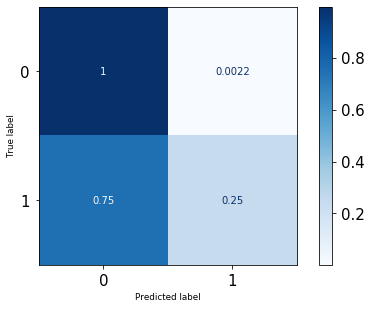

In [18]:
plot_confusion_matrix(lda_p0_model.fit(X_train,y_train),
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.tight_layout()

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
lda = {'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}
lda

{'tn': 3183, 'fp': 7, 'fn': 83, 'tp': 27}

**(R)** El desempeño del modelo deja ver las clases desbalanceadas: la etiqueta `0` (cliente no-moroso) tiene una _precision_, _recall_ y _f1-score_ casi perfectos, con un _support_ (N) grande en comparación con la clase `1` (cliente moroso). En general, la _accuracy_ del modelo es bastante buena, con una matriz de confusión que confirma la gran cantidad de _true negatives_ en comparación a los _true positives_; y muy pocos falsos negativos/positivos. Dado que a un banco en general le gustaría más bien predecir los morosos (clase `1`) que los no-morosos (clase `0`), **queremos un modelo que tenga más `TP` (predichos morosos que realmente lo son) y menos `FN` (predichos no-morosos que en realidad sí lo son)**.

### **Ejercicio 3: Refactorización 1 - información a priori**

#### **(3.1)** Prior 1 → morosos : no-morosos = 50:50

In [20]:
prior_1 = np.array([0.5,0.5])
lda_p1_model = LinearDiscriminantAnalysis(priors=prior_1)
lda_p1_model.fit(X_train,y_train);

In [21]:
lda_p1_model.priors_

array([0.5, 0.5])

In [22]:
y_pred_p1 = lda_p1_model.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred_p1))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3190
           1       0.17      0.87      0.28       110

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.89      3300



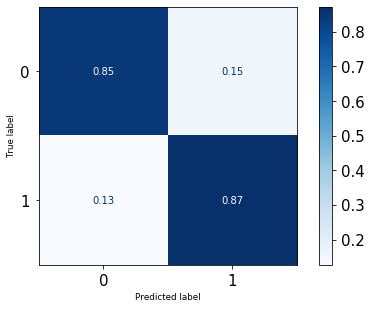

In [24]:
plot_confusion_matrix(lda_p1_model.fit(X_train,y_train),
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.tight_layout()

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_p1).ravel()
lda_p1 = {'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}
lda_p1

{'tn': 2705, 'fp': 485, 'fn': 14, 'tp': 96}

#### **(3.2)** Prior 2 → morosos : no-morosos = 60:40

In [26]:
prior_2 = np.array([0.6,0.4])
lda_p2_model = LinearDiscriminantAnalysis(priors=prior_2)
lda_p2_model.fit(X_train,y_train);

In [27]:
lda_p2_model.priors_

array([0.6, 0.4])

In [28]:
y_pred_p2 = lda_p2_model.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred_p2))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3190
           1       0.21      0.85      0.33       110

    accuracy                           0.89      3300
   macro avg       0.60      0.87      0.63      3300
weighted avg       0.97      0.89      0.92      3300



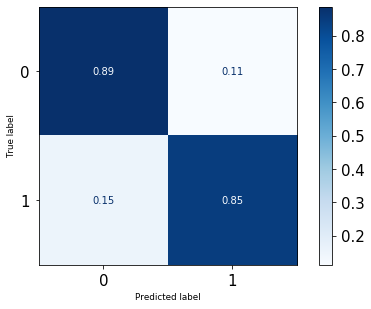

In [30]:
plot_confusion_matrix(lda_p2_model.fit(X_train,y_train),
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.tight_layout()

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_p2).ravel()
lda_p2 = {'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}
lda_p2

{'tn': 2830, 'fp': 360, 'fn': 17, 'tp': 93}

Notar que el desbalanceo de las etiquetas disminuye un poco al asumir distintos _priors_. En general, la `accuracy` del modelo sigue siendo bastante buena, con una matriz de confusión que aumenta la cantidad de `TN` pero disminuye a su vez la cantidad de `TP`.

### **Ejercicio 4: Refactorización 2 - oversampling**

In [32]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=42, sampling_strategy='minority')
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [33]:
lda_over_model = LinearDiscriminantAnalysis()
lda_over_model.fit(X_train_oversamp, y_train_oversamp);

In [34]:
lda_over_model.priors_

array([0.5, 0.5])

In [35]:
y_pred_over = lda_over_model.predict(X_test)

In [36]:
print(classification_report(y_test, y_pred_over))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3190
           1       0.17      0.88      0.29       110

    accuracy                           0.85      3300
   macro avg       0.58      0.87      0.60      3300
weighted avg       0.97      0.85      0.90      3300



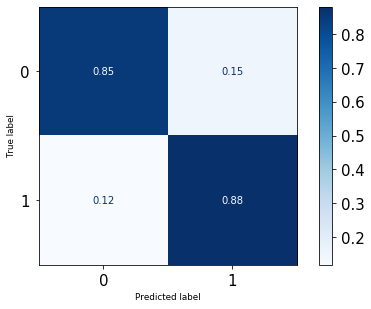

In [37]:
plot_confusion_matrix(lda_over_model.fit(X_train_oversamp,y_train_oversamp),
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.tight_layout()

In [38]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_over).ravel()
lda_over = {'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}
lda_over

{'tn': 2717, 'fp': 473, 'fn': 13, 'tp': 97}

**(R)** Vemos que aunque este modelo tiene menos TN, tiene más TP y menos FN (que es lo que nos interesa desde el punto de vista del banco). Las métricas en general siguen siendo relativamente buenas.

### **Ejercicio 5: Refactorización 3 - QDA**

In [39]:
qda_over_model = QuadraticDiscriminantAnalysis()
qda_over_model.fit(X_train_oversamp,y_train_oversamp);

In [40]:
qda_over_model.priors_

array([0.5, 0.5])

In [41]:
y_pred_qda_over = qda_over_model.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred_qda_over))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3190
           1       0.19      0.85      0.32       110

    accuracy                           0.88      3300
   macro avg       0.59      0.86      0.62      3300
weighted avg       0.97      0.88      0.91      3300



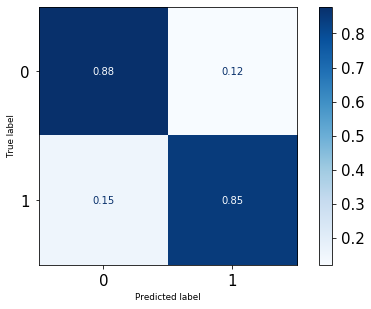

In [43]:
plot_confusion_matrix(qda_over_model.fit(X_train_oversamp,y_train_oversamp),
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.tight_layout()

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_qda_over).ravel()
qda_over = {'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}
qda_over

{'tn': 2804, 'fp': 386, 'fn': 17, 'tp': 93}

**(R)** No hay mucha diferencia con los modelos anteriores.

Veamos un resumen para entender mejor:

In [45]:
def get_scores(cm_object):
    tn, fp, fn, tp = cm_object.ravel()
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    neg_pred_value = tn / (tn + fn)
    f1 = 2*(precision * sensitivity)/(precision + sensitivity)
    """
    precision (positive predictive value): probability that instances predicted positive are actually positive
    → a measure of QUALITY
    accuracy: fraction of correct predictions among the total number of input samples
    sensitivity (recall): how many of the actual positives our model capture through labeling it as positive
    → a measure of QUANTITY (completeness)
    neg_pred_value: probability that instances predicted negative are actually negative
    f1: (precision plus recall) a combined measure of how many instances are classified correctly,
        as well as how robust it is by not missing a significant number of instances
    → a measure of TEST'S ACCURACY
    """
    return {'precision': round(precision,2),
            'accuracy': round(accuracy,2),
            'sensitivity': round(sensitivity,2),
            'specificity': round(specificity,2),
            'NPV': round(neg_pred_value,2),
            'f1': round(f1,2)}

In [46]:
cm_lda = confusion_matrix(y_test, y_pred)
cm_lda_p1 = confusion_matrix(y_test, y_pred_p1)
cm_lda_p2 = confusion_matrix(y_test, y_pred_p2)
cm_lda_ov = confusion_matrix(y_test, y_pred_over)
cm_qda = confusion_matrix(y_test, y_pred_qda_over)
d1 = pd.DataFrame.from_dict(get_scores(cm_lda), orient='index', columns=['lda'])
d2 = pd.DataFrame.from_dict(get_scores(cm_lda_p1), orient='index', columns=['lda_p1'])
d3 = pd.DataFrame.from_dict(get_scores(cm_lda_p2), orient='index', columns=['lda_p2'])
d4 = pd.DataFrame.from_dict(get_scores(cm_lda_ov), orient='index', columns=['lda_over'])
d5 = pd.DataFrame.from_dict(get_scores(cm_qda), orient='index', columns=['qda_over'])
frames = [d1, d2, d3, d4, d5]
metrics = pd.concat(frames, axis=1)

In [47]:
d1_ = pd.DataFrame.from_dict(lda, orient='index', columns=['lda'])
d2_ = pd.DataFrame.from_dict(lda_p1, orient='index', columns=['lda_p1'])
d3_ = pd.DataFrame.from_dict(lda_p2, orient='index', columns=['lda_p2'])
d4_ = pd.DataFrame.from_dict(lda_over, orient='index', columns=['lda_over'])
d5_ = pd.DataFrame.from_dict(qda_over, orient='index', columns=['qda_over'])
frames_ = [d1_, d2_, d3_, d4_, d5_]
confusion = pd.concat(frames_, axis=1)

In [48]:
results = pd.concat([metrics, confusion])
results

,lda,lda_p1,lda_p2,lda_over,qda_over
precision,0.79,0.17,0.21,0.17,0.19
accuracy,0.97,0.85,0.89,0.85,0.88
sensitivity,0.25,0.87,0.85,0.88,0.85
specificity,1.00,0.85,0.89,0.85,0.88
NPV,0.97,0.99,0.99,1.00,0.99
f1,0.38,0.28,0.33,0.29,0.32
tn,3183.00,2705.00,2830.00,2717.00,2804.00
fp,7.00,485.00,360.00,473.00,386.00
fn,83.00,14.00,17.00,13.00,17.00
tp,27.00,96.00,93.00,97.00,93.00


Veamos qué modelos optimizan la mayor cantidad de métricas de rendimiento:

In [49]:
results.drop(['fp', 'fn']).idxmax(axis=1)

precision           lda
accuracy            lda
sensitivity    lda_over
specificity         lda
NPV            lda_over
f1                  lda
tn                  lda
tp             lda_over
dtype: object

In [50]:
results.loc[['fp', 'fn']].idxmin(axis=1)

fp         lda
fn    lda_over
dtype: object

**(R)** En general, vemos que efectivamente el modelo LDA con _oversampling_ `lda_over` no necesariamente tiene las mejores métricas como un todo, pero sí tiene mejores métricas desde el punto de vista del banco: mejor `recall` (`sensitivity`: capacidad de recuperar casos morosos que realmente lo son), mejor `NPV` (`negative predictive value`: capacidad de predecir no-morosos que realmente son no-morosos), más `TP` y menos `TN`. El mejor modelo en este caso sería entonces el que viene de LDA con _oversampling_.

Ahora miremos las curvas AUC para analizar los modelos:

In [51]:
y_pred_probs = [
    lda_p0_model.predict_proba(X_test)[:,1],
    lda_p1_model.predict_proba(X_test)[:,1],
    lda_p2_model.predict_proba(X_test)[:,1],
    lda_over_model.predict_proba(X_test)[:,1],
    qda_over_model.predict_proba(X_test)[:,1]
]

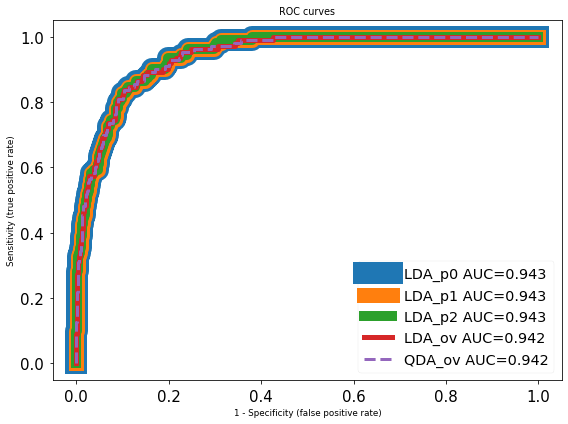

In [52]:
plt.rcParams['figure.figsize'] = 8, 6
linestyles = ['solid', 'solid', 'solid', 'solid', 'dashed']
linewidths = [22, 15, 10, 5, 3]
#linewidths = [3, 3, 3, 3, 3]
model_labels = ['LDA_p0', 'LDA_p1', 'LDA_p2', 'LDA_ov', 'QDA_ov']
for (pred, ls, lw, ml) in zip(y_pred_probs, linestyles, linewidths, model_labels):
    auc = roc_auc_score(y_test, pred)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    lb = ml + f' AUC={auc:0.3f}'
    plt.plot(fpr, tpr, label=lb, linestyle=ls, linewidth=lw)
    plt.xlabel('1 - Specificity (false positive rate)')
    plt.ylabel('Sensitivity (true positive rate)')
    plt.title('ROC curves')
    plt.legend(fontsize='x-large')
plt.tight_layout()

**(R)** Desde el punto de vista de las curvas ROC, el comportamiento de las curvas y el puntaje AUC son esencialmente los mismos a través de los distintos modelos; es decir, todos los modelos tienen la misma capacidad de separar ambas poblaciones.